In [47]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_DF_PATH = '/content/drive/MyDrive/train-2.csv'
VAL_DF_PATH = '/content/drive/MyDrive/val-2.csv'
TEST_DF_PATH = '/content/drive/MyDrive/evaluation.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(VAL_DF_PATH)
df[df.retweet_count.isna()].shape
df['retweet_count'].fillna(0, inplace=True)
df.shape

df = df.sample(100)[['text']]

In [58]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [59]:
df.sample(10)

,text
58063,And lie \n\n🤣🤣🤣🤣
29327,Gombe and kano burst my ticket.
18116,Covid-19 if fucking bad
96722,This article starts with the story of the #homerton hospital consultant who tragically died after his request for more #PPE fell on deaf ears.
105718,"Default, Dim, Lights Out, Novel Coronavirus"
27945,"HEALTH PROFESSIONAL RESOURCES: 👉🏿 https://t.co/nSbxJHhZjU 👈🏿 \nCOVID-19 Info to support Karen, Afghan and South Sudanese communities by @Bendigo_health via Health Translations \n#COVID19Australia #COVID19Aus https://t.co/kvUjwPjwuN"
131338,Beautiful and heartbreaking and hopeful all at the same time.
81977,Humans will never cease to amaze me.
14253,"#CoronaVirus-Data shows that up to 30% of people hospitalized with #COVID19 develop kidney failure, a complication in people with diabetes. IDF supports @ISNkidneycare, @ERAEDTA &amp; @ASNKidney’s request to government agencies to oversee dialysis centers: https://t.co/wyq3y9DO9w https://t.co/QsQIBqR2g6"
26261,"I reckon we can hit the halfway mark by tonight insha’Allah, please do what you can 👇🏽👇🏽👇🏽"


In [59]:
!pip install emoji

In [127]:
from emoji import UNICODE_EMOJI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from string import punctuation


def clean_texts(df):
    # remove URL
    df['text_proc'] = df['text'].str.replace(r'http(\S)+', r'')
    df['text_proc'].fillna('', inplace=True)
    df['text_proc'] = df['text_proc'].str.replace(r'http ...', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'http', r'')

    # remove RT, @
    df['text_proc'] = df['text_proc'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'@[\S]+', r'')

    # remove non-ascii words and characters
    df['text_proc'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in df['text_proc'].values]
    df['text_proc'] = df['text_proc'].str.replace(r'_[\S]?', r'')

    # remove &, < and >
    df['text_proc'] = df['text_proc'].str.replace(r'&amp;?', r'and')
    df['text_proc'] = df['text_proc'].str.replace(r'&lt;', r'<')
    df['text_proc'] = df['text_proc'].str.replace(r'&gt;', r'>')

    # remove extra space
    df['text_proc'] = df['text_proc'].str.replace(r'[ ]{2, }', r' ')

    # insert space between punctuation marks
    df['text_proc'] = df['text_proc'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
    df['text_proc'] = df['text_proc'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')

    # lower case and strip white spaces at both ends
    df['text_proc'] = df['text_proc'].str.lower()
    df['text_proc'] = df['text_proc'].str.strip()
    return df


def add_text_features(df_):
    df = df_.copy()
    df = clean_texts(df)
    df['text'].fillna('', inplace=True)
    df['text_length'] = df['text'].str.len()
    df['text_proc_length'] = df['text_proc'].str.len()
    df['text_proc_length_to_text_length'] = df['text_proc_length'] / df['text_length']
    df['text_lines_count'] = df['text'].str.count('\n')
    df['text_word_count'] = df['text'].str.split().apply(len)
    df['text_proc_word_count'] = df['text_proc'].str.split().apply(len)
    df['text_proc_word_count_to_text_word_count'] = df['text_proc_word_count'] / df['text_word_count']
    df['text_mean_word_length'] = df['text'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length'] = df['text_proc'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length_to_text_mean_word_length'] = df['text_proc_mean_word_length'] / df['text_mean_word_length']
    df['text_proc_alphas_count'] = df['text_proc'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_alphas_count'] = df['text'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_proc_alphas_count_to_text_alphas_count'] = df['text_proc_alphas_count'] / df['text_alphas_count']
    df['text_alphas_percent'] = df['text_alphas_count'] / df['text_length']
    df['text_non_alphas_count'] = df['text'].apply(lambda s: sum(not c.isalpha() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_emoji_count'] = df['text'].apply(lambda s: sum(c in UNICODE_EMOJI for c in s))
    df['text_emoji_percent'] = df['text_emoji_count'] / df['text_length']
    df['text_has_emoji'] = (df['text_emoji_count'] > 0).astype(int)
    df['text_upper_letter_count'] = df['text'].apply(lambda s: sum(1 for c in s if c.isupper()))
    df['text_upper_letter_count_to_word_count'] = df['text_upper_letter_count'] / df['text_word_count']
    df['text_upper_letter_count_to_length'] = df['text_upper_letter_count'] / df['text_length']
    df['text_urls_count'] = df['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
    df['text_urls_count_to_words_count'] = df['text_urls_count'] / df['text_word_count']
    df['text_hashtags_count'] = df['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
    df['text_hashtags_count_to_words_count'] = df['text_hashtags_count'] / df['text_word_count']
    df['text_usertag_count'] = df['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))
    df['text_usertags_count_to_words_count'] = df['text_usertag_count'] / df['text_word_count']
    df['text_punctuation_count'] = df['text'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_proc_punctuation_count'] = df['text_proc'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_punctuation_rate'] = df['text_punctuation_count'] / df['text_length']
    df['text_punctuation_to_alpha'] = df['text_punctuation_count'] / df['text_alphas_count']
    df['text_proc_punctuation_to_alpha'] = df['text_proc_punctuation_count'] / df['text_proc_alphas_count']
    df['text_punctuation_unique_count'] = df['text'].apply(lambda s: len(set([c for c in s if c in punctuation])))
    df['text_proc_count_!'] = df['text_proc'].apply(lambda s: sum(c == '!' for c in s))
    df['text_proc_count_?'] = df['text_proc'].apply(lambda s: sum(c == '?' for c in s))

    return df

In [128]:
df2 = add_text_features(df)
df2.head(50)

,text,text_proc,text_length,text_proc_length,text_proc_length_to_text_length,text_lines_count,text_word_count,text_proc_word_count,text_proc_word_count_to_text_word_count,text_mean_word_length,text_proc_mean_word_length,text_proc_mean_word_length_to_text_mean_word_length,text_proc_alphas_count,text_alphas_count,text_proc_alphas_count_to_text_alphas_count,text_alphas_percent,text_non_alphas_count,text_digits_count,text_emoji_count,text_emoji_percent,text_has_emoji,text_upper_letter_count,text_upper_letter_count_to_word_count,text_upper_letter_count_to_length,text_urls_count,text_urls_count_to_words_count,text_hashtags_count,text_hashtags_count_to_words_count,text_usertag_count,text_usertags_count_to_words_count,text_punctuation_count,text_proc_punctuation_count,text_punctuation_rate,text_punctuation_to_alpha,text_proc_punctuation_to_alpha,text_punctuation_unique_count,text_proc_count_!,text_proc_count_?
15841,"And a record 13,000 tests completed on Sunday.","and a record 13 , 000 tests completed on sunday .",46,49,1.065217,0,8,11,1.375000,4.875000,3.545455,0.727273,32,32,1.000000,0.695652,14,5,0,0.000000,0,2,0.250000,0.043478,0,0.000000,0,0.000000,0,0.000000,2,2,0.043478,0.062500,0.062500,2,0,0
120916,And the government you idiots put into power does not give a shit.,and the government you idiots put into power does not give a shit .,66,67,1.015152,0,13,14,1.076923,4.153846,3.857143,0.928571,53,53,1.000000,0.803030,13,0,0,0.000000,0,1,0.076923,0.015152,0,0.000000,0,0.000000,0,0.000000,1,1,0.015152,0.018868,0.018868,1,0,0
52365,Bill Gates is a worried man since the Madagascar Cure for coronavirus is already working. 97 patients out of 135 cases in Madagascar have recovered fully. Africa it's the highest time we start believing in ourselves. Kenya we are ready to test the cure.\n#MadagascarCure https://t.co/R6WVMdg9po,bill gates is a worried man since the madagascar cure for coronavirus is already working . 97 patients out of 135 cases in madagascar have recovered fully . africa it ' s the highest time we start believing in ourselves . kenya we are ready to test the cure .\n# madagascarcure,293,276,0.941980,1,46,52,1.130435,5.391304,4.326923,0.802574,214,230,0.930435,0.784983,63,7,0,0.000000,0,13,0.282609,0.044369,1,0.021739,1,0.021739,0,0.000000,11,6,0.037543,0.047826,0.028037,5,0,0
130322,THUNDERDOME.,thunderdome .,12,13,1.083333,0,1,2,2.000000,12.000000,6.000000,0.500000,11,11,1.000000,0.916667,1,0,0,0.000000,0,11,11.000000,0.916667,0,0.000000,0,0.000000,0,0.000000,1,1,0.083333,0.090909,0.090909,1,0,0
68155,"Doctor presents irrefutable proof of inflated, inaccurate COVID-19 numbers. Wow.\n\n#Covid_19 #coronavirus #Coronavirustruth #CoronaVirusHOAX #cdc #WHO #FauciFraud #SayNoToBillGates https://t.co/xZtZmXoY6I","doctor presents irrefutable proof of inflated , inaccurate covid - 19 numbers . wow .\n\n# covid9 # coronavirus # coronavirustruth # coronavirushoax # cdc # who # faucifraud # saynotobillgates",203,190,0.935961,2,19,31,1.631579,9.684211,5.129032,0.529628,144,161,0.894410,0.793103,42,5,0,0.000000,0,30,1.578947,0.147783,1,0.052632,8,0.421053,0,0.000000,18,12,0.088670,0.111801,0.083333,7,0,0
114778,"Hair salons, barbershops and tanning salons will be allowed to reopen on Friday. https://t.co/1CLvFX0rGz","hair salons , barbershops and tanning salons will be allowed to reopen on friday .",104,82,0.788462,0,14,15,1.071429,6.500000,4.533333,0.697436,66,82,0.804878,0.788462,22,2,0,0.000000,0,7,0.500000,0.067308,1,0.071429,0,0.000000,0,0.000000,7,2,0.067308,0.085366,0.030303,4,0,0
21180,People on immunosuppression therapies sufficient to significantly increase risk of infection should follow @govuk and @phe_uk advice to self isolate for 12 weeks. Visit https://t.co/ENGqKFr1sF for more information #coronavirus #warwickshirenorth https://t.co/US1BwMrTxV,people on immunosuppression therapies sufficient to significantly increase risk of infection should follow and advice to self isolate for 12 weeks . visit for more information # c

In [107]:
df = pd.read_csv(TRAIN_DF_PATH)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [108]:
df2 = add_text_features(df)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


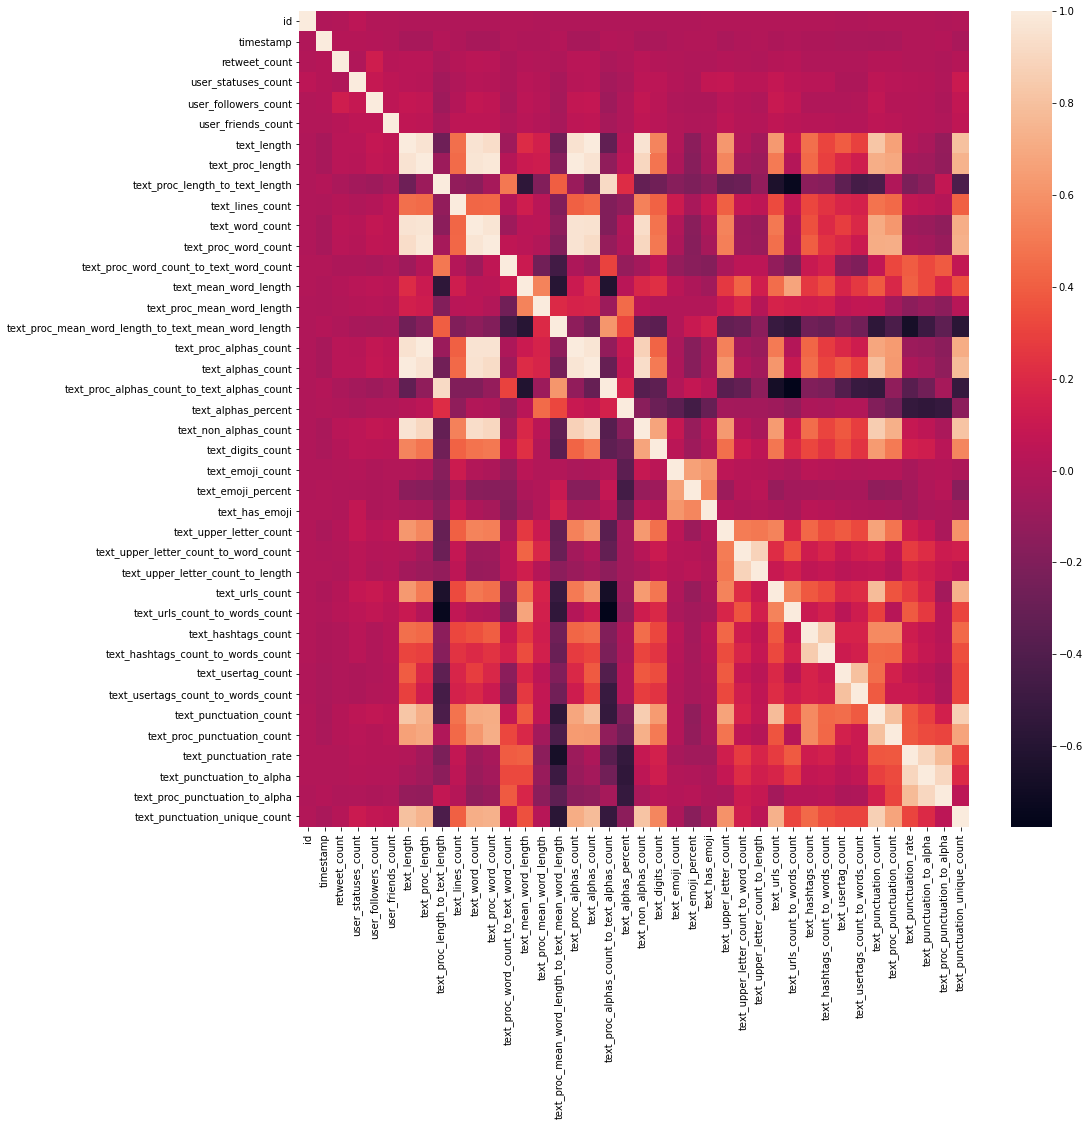

In [111]:
import seaborn as sns

corr = df2.corr()

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [115]:
corr_matrix=df2.corr()
corr_matrix["retweet_count"].sort_values(key=lambda x: abs(x), ascending=False)

retweet_count                                          1.000000
user_followers_count                                   0.128482
text_word_count                                        0.037121
text_proc_word_count                                   0.035687
text_proc_alphas_count                                 0.034519
text_proc_length                                       0.034486
text_length                                            0.032541
text_non_alphas_count                                  0.032151
text_alphas_count                                      0.032148
text_proc_alphas_count_to_text_alphas_count           -0.024336
text_urls_count_to_words_count                         0.024297
text_proc_length_to_text_length                       -0.023614
user_friends_count                                     0.023413
timestamp                                              0.022008
text_punctuation_unique_count                          0.019864
text_lines_count                        

In [56]:


# cccc = Counter(df.retweet_count.values)